In [1]:
from sklearn.linear_model import SGDClassifier
%matplotlib inline 
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8)
sort_by_target(mnist)
mnist["data"],mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

这里就是把数据进行了分组。
- X：特征
- y：目标

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape
X_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [4]:
X_train[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

这个函数，本质上来说，就是把东西拼接数组，组成一个比较大的数组。然后打印那个数组。  

计算机的图片就是一个一个像素点。而一个train set的中的单元，逻辑上来说是一张一张图片，而实现上来说，只是像素点组合成的数组。
而下面这个函数，就是把这些像素点组成的数组拼装起来。

In [5]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

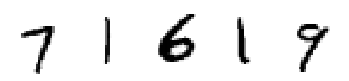

In [6]:
import matplotlib
import matplotlib.pyplot as plt

plot_digits(X_train[:5])
plt.show()

In [7]:
y_train[:5]

array([7, 1, 6, 1, 9], dtype=int8)

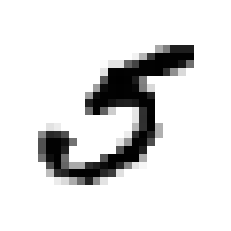

In [8]:
%matplotlib inline 

five_example = mnist["data"][36000]
image = five_example.reshape(28, 28)
plt.axis("off")
plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.show()

mnist 数据的类型，就是把一张图片，拍平成一个数组。然后对数组进行对比。

In [9]:
"每个元素的类型，本质上来说是，{}".format(type(five_example))

"每个元素的类型，本质上来说是，<class 'numpy.ndarray'>"

In [10]:
sgd_clf = SGDClassifier(random_state=42, max_iter=5, tol=-np.infty)
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

        
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([five_example])

array([ True])

下面是交叉验证。

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import  clone
skfolds = StratifiedKFold(n_splits=3, random_state=42,shuffle=True)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf= clone(sgd_clf)
    x_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    x_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred = clone_clf.predict(x_test_fold)
    
    n_correct = sum(y_pred == y_test_fold)
    
    print("correct is {}".format(n_correct/len(y_pred)))

correct is 0.96685
correct is 0.9332
correct is 0.96385


下面的两个模型，一个是正经的干活，一个是唯一答案。然后发觉两者其实结果差不多的。  

从另一个角度，其实AI本质还是一个找寻概率的问题。找寻概率高的那个，而有时候，猜比较大概率那个也是一种省力的办法。这里的问题还是有点神奇的。

如果以现在的只是来看。这里的工作也就高出了5%左右的正确率。。。

In [12]:

from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9623, 0.9621, 0.9685])

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,x,y=None):
        pass
    def predict(self,x):
        return np.zeros((len(x),1),dtype=bool) # return all 5

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.9074 , 0.91165, 0.9099 ])

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
y_train_pred

array([False, False, False, ..., False, False, False])

这个是一个比对的结果

|     说明        |  模型判断为非         | 模型判断为负  |
| :-------------  | :----------:        |  -----------: |
|  负类           | 真负类（非5 认为非5）  | 假正类（非5非认为5）    |
|  正类           | 假负类（为5，认为5非）  | 真正类（为5，认为5） |

In [15]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_train_5,y_train_pred)
matrix

array([[53890,   689],
       [ 1453,  3968]])

In [16]:
from sklearn.metrics import precision_score,recall_score,f1_score
precision = precision_score(y_train_5,y_train_pred)
recall= recall_score(y_train_5,y_train_pred)
f1 = f1_score(y_train_5,y_train_pred)
"precision score is {}, recall score is {}, f1 score is {}".format(precision,recall,f1)


'precision score is 0.8520506764011166, recall score is 0.7319682715366168, f1 score is 0.7874578289343123'

- 精度：一堆里面，找出来的是准确度高. 结果里面的**杂质**会更加少。
- 召回率： 一堆满足的里面，能够召回几个。正确的结果**漏掉**会更加少


打个比方：100个球，10个红的，90个黑的。找红球

精度，追求的是我找到找到的球红色的多。那么最好的策略，就是去少找球。因为相同的概率下，找的次数越多，黑球出现的概率就越大。
极端情况下，我找一个，只要那个是红球。那么精度就是100%。  

召回率，追求的红球的数量越多，或者说剩余的球里面红球越少。那么我必须要找10次。因为有是个球。但是概率的原因，10个球里面必然有一个黑球。
那么我就要找11次。召回率越高，我的找寻次数就越少。

其实这个两个很奇怪。要么都是100%。否则，就是此消彼长的关系。

In [17]:
TP = matrix[1,1]
FP = matrix[0,1]
FN = matrix[1,0]
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1 = TP/(TP+(FN+FP)/2)
"precision score is {}, recall score is {}, f1 score is {}".format(precision,recall,f1)


'precision score is 0.8520506764011166, recall score is 0.7319682715366168, f1 score is 0.7874578289343124'

下面这个，就是自己做比较。具体我还是不太清楚了。估计和算法了解相关。  
发觉到了这里，整体来说就比较好理解了。

至少对于`SGDClassifier`这个算法来说。之后的流程，就是把数据按照相似度来排序。而阀值本质就是用来作为相关度的**最小值**。  
而算这个相似度算法的，的精度和召回率，就是这个算法的衡量指标。对于业余的来说，就是一个**黑盒**。

天下没有完美的算法，造成了这个相似度*计算失误*，也就是造成了那么多问题在那里。

In [18]:
y_scores_simple = sgd_clf.decision_function(X_train)
y_scores_simple.shape

(60000,)

In [19]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores

array([-342934.18273004,  -87564.90228587, -337750.17683947, ...,
       -268814.69822693, -880072.31642402, -761852.52428576])

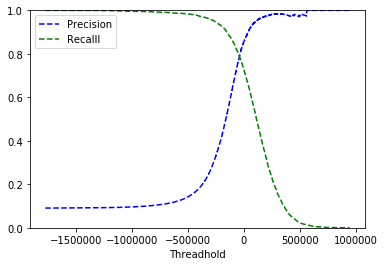

In [20]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_threadhold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g--",label="Recalll")
    plt.xlabel("Threadhold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])

plot_precision_recall_vs_threadhold(precisions,recalls,thresholds)
plt.show()

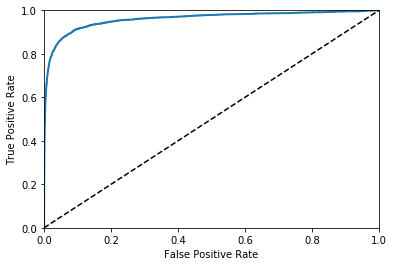

In [21]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr,tpr)
plt.show()

fpr(假正类率）：混入正类的假概率。分母是负类的综合，在负类中占的概率。

下面的这张图，其实就是为了防止假负类率，所以就阿猫阿狗全都进如选择。最后导致，负类内选取的数量不断提高。最后全部选进来了。

In [22]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604318659157128

随机森林方法

In [23]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

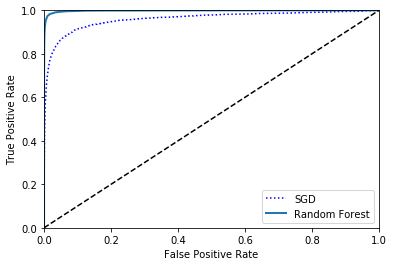

In [24]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest = roc_curve(y_train_5,y_scores_forest)
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest,tpr_forest,"Random Forest")
plt.legend(loc="lower right")
plt.show()

下面这个明显变慢了。因为他要自动生成好几个分类器。

OvO: One vs One, 需要训练数据少，但是分类器多。  
OvR: One vs Rest 相反

这个区别其实挺好理解的。因为OvO就是两个比对。但是OvR则是群体比对。  
不过我不清楚Ovo是怎么选择最后谁胜出的。因为这个还是有点神奇的。

In [25]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [26]:
five_example = X[36000]
sgd_clf.predict([five_example])

array([5], dtype=int8)

In [27]:
example_score = sgd_clf.decision_function([five_example])
example_score

array([[-230706.00737506, -420807.59961222, -320107.92784566,
         -86298.2087306 , -441608.07907253,  147649.0473237 ,
        -878678.57166458, -358877.54930192, -613313.36925143,
        -876947.67850635]])

In [28]:
np.argmax(example_score)

5

In [29]:
"""
目标的列表，估计是列表的真实值吧。
"""
sgd_clf.classes_ 

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [30]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=5, tol=-np.infty))
ovo_clf.fit(X_train,y_train)
ovo_clf.predict([five_example])

array([5], dtype=int8)

In [31]:
len(ovo_clf.estimators_)

45

In [32]:
forest_clf.fit(X_train,y_train)
forest_clf.predict([five_example])

array([5], dtype=int8)

In [33]:
forest_clf.predict_proba([five_example])

array([[0.02, 0.  , 0.  , 0.08, 0.02, 0.83, 0.01, 0.02, 0.01, 0.01]])

In [34]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.85835, 0.857  , 0.863  ])

In [35]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")


array([0.90935, 0.911  , 0.91065])

所有的交叉，就是把数据分类n份，然后做n次。  
每次都把一个给弄出来，用其他来做训练，来评估他。  
最后返回一个整体

In [36]:
from functools import partial

my_score = partial(cross_val_score,cv=3,scoring="accuracy")
my_score(sgd_clf,X_train_scaled,y_train)


array([0.90935, 0.911  , 0.91065])

## 错误分析


In [37]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

array([[5729,    3,   21,    8,   13,   53,   44,    8,   40,    4],
       [   1, 6490,   45,   24,    6,   46,    7,    9,  102,   12],
       [  55,   41, 5321,   96,   82,   31,   85,   61,  172,   14],
       [  50,   39,  152, 5321,    1,  244,   32,   57,  139,   96],
       [  16,   29,   35,    8, 5364,   10,   51,   29,   88,  212],
       [  78,   34,   33,  170,   68, 4651,  103,   26,  164,   94],
       [  37,   26,   37,    2,   49,   97, 5616,    8,   46,    0],
       [  29,   25,   64,   29,   56,   10,    3, 5817,   15,  217],
       [  51,  153,   62,  148,   11,  165,   59,   27, 5045,  130],
       [  42,   35,   29,   86,  146,   34,    2,  223,   86, 5266]])

这张图，数字越小。表示就越黑。白的地方，反而表示正确率越高。

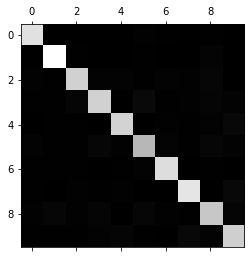

In [38]:
plt.matshow(conf_mx,cmap=plt.cm.gray)

下面的处理，做的是一个反处理。算百分比。这个百分比是错误率。  
因为除了对角线之外,其他都是错误的。就是错误数据的百分比。这个百分比越高，值越大，就会显示越白。

其实这里比较难以理解的是，对角线是正确率。其他都是错误率

In [39]:
row_sums = conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx = conf_mx/row_sums
norm_conf_mx

array([[9.67246328e-01, 5.06500084e-04, 3.54550059e-03, 1.35066689e-03,
        2.19483370e-03, 8.94816816e-03, 7.42866790e-03, 1.35066689e-03,
        6.75333446e-03, 6.75333446e-04],
       [1.48323939e-04, 9.62622367e-01, 6.67457728e-03, 3.55977455e-03,
        8.89943637e-04, 6.82290122e-03, 1.03826758e-03, 1.33491546e-03,
        1.51290418e-02, 1.77988727e-03],
       [9.23128567e-03, 6.88150386e-03, 8.93084928e-01, 1.61127895e-02,
        1.37630077e-02, 5.20308828e-03, 1.42665324e-02, 1.02383350e-02,
        2.88687479e-02, 2.34978181e-03],
       [8.15527646e-03, 6.36111564e-03, 2.47920405e-02, 8.67884521e-01,
        1.63105529e-04, 3.97977491e-02, 5.21937694e-03, 9.29701517e-03,
        2.26716686e-02, 1.56581308e-02],
       [2.73878809e-03, 4.96405341e-03, 5.99109894e-03, 1.36939404e-03,
        9.18178706e-01, 1.71174255e-03, 8.72988702e-03, 4.96405341e-03,
        1.50633345e-02, 3.62889421e-02],
       [1.43884892e-02, 6.27190555e-03, 6.08743774e-03, 3.13595278e-02,
   

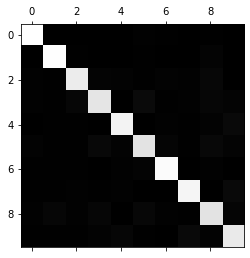

In [40]:
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

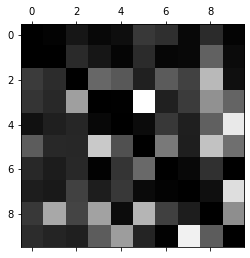

In [41]:
np.fill_diagonal(norm_conf_mx,0) #如果不知空，那么其他都是值太小
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)

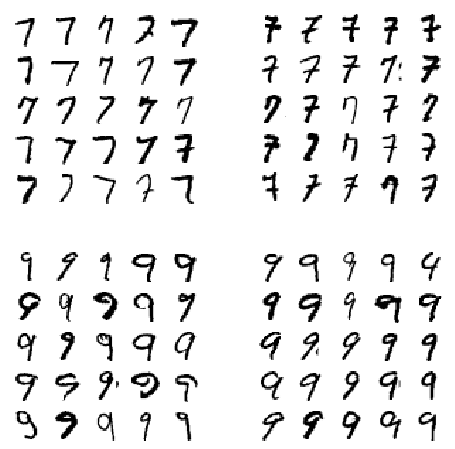

In [42]:
cl_a,cl_b = 7,9
X_aa = X_train[(y_train==cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train==cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train==cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train==cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5) # 3的真正类
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5) # 3的假正类
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5) # 5的假真类
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5) # 5的真真类
plt.show()

## 多标签分类
一个数据加上两个标签

In [43]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [44]:
knn_clf.predict([five_example])

array([[False,  True]])

下面这个很慢。

In [45]:
#y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_train,cv=3)
#f1_score(y_train,y_train_knn_pred,average="marcro")

## 多输出分类 

这里是输出和输入都是多标签。

就这里的例子来说。他做了这么几步
1. 给数据集加上噪音。
2. 把原始的数据，当成目标集合。也就是输出的集合。

这里，读每个像素点，都做了一个归类。然后这些归好类的像素点，最后汇集成了一幅图。
预测结果，就是一副图片（784个像素组成的图片）

有噪音的图片 --》 干净的图片

In [46]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(x_test), 784))
X_test_mod = x_test + noise
y_train_mod = X_train
y_test_mod = x_test

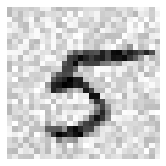

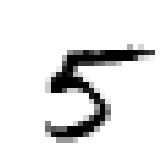

In [47]:
def plot_digit(digit):
    image = digit.reshape(28, 28)
    plt.axis("off")
    plt.imshow(image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.show()


some_index = 5500
plt.subplot(121);plot_digit(X_test_mod[some_index])
plt.subplot(122);plot_digit(x_test[some_index])

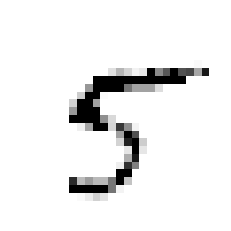

In [48]:
knn_clf.fit(X_train_mod,y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
